In [1]:
import wfdb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Download data if it is not in data folder

In [2]:
wfdb.dl_database("mitdb", "data/mit-bih", annotators='all')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [3]:
data = 'data/mit-bih/'

In [4]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Classification based on AAMI
AAMI = ['N','L','R','B','A','a','j','S','V','r','F','e','j','n','E','f','/','Q','?']

# Normal Beat Symbols
normal = ['N']

dic = {'N':['N','L','R','B'],
       'S':['A','a','j','S','e','j','n'],
       'V':['V','r','E'],
       'F':['F'],
       'Q':['Q','?','f','/'],
      }


In [5]:
record = wfdb.rdrecord(data+'100',smooth_frames=True)
record.p_signal.shape
# first entry is MLII (Lead II) and second is V1 (sometimes V2, V4, or V5) 

(650000, 2)

In [6]:
t = [x/360 for x in list(range(10800))]

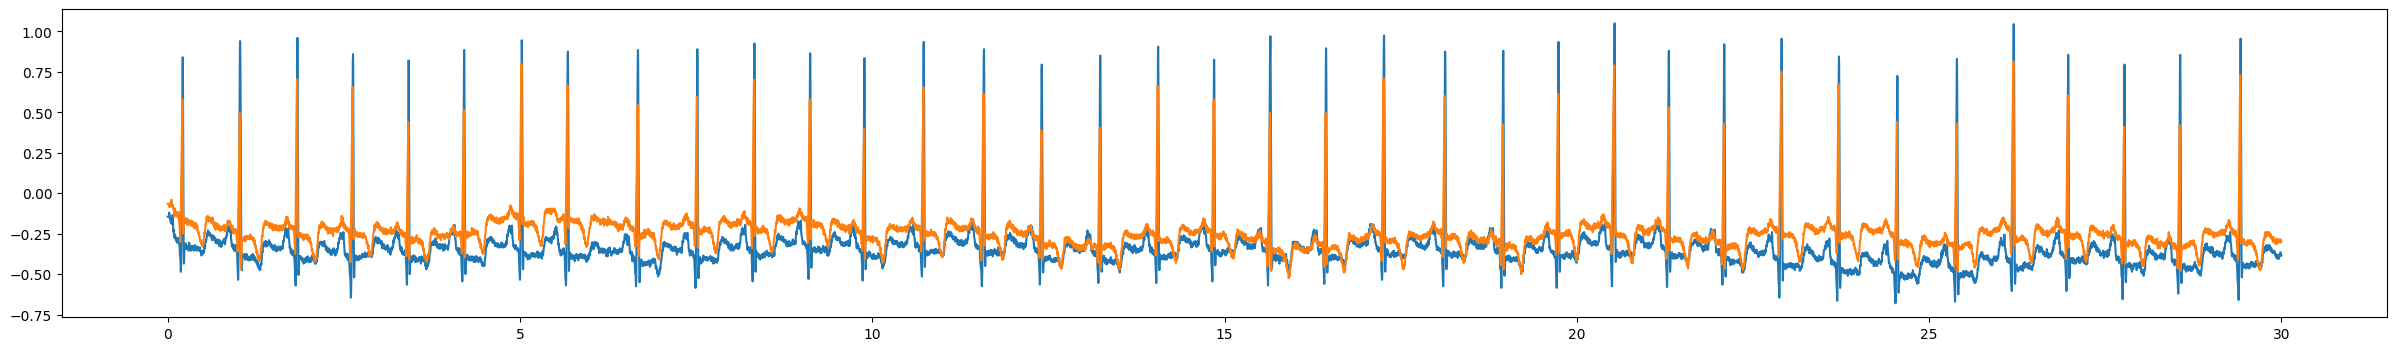

In [7]:
plt.figure(figsize=(30, 4))
plt.plot(t, record.p_signal[:10800,0])
plt.plot(t, record.p_signal[:10800,1])

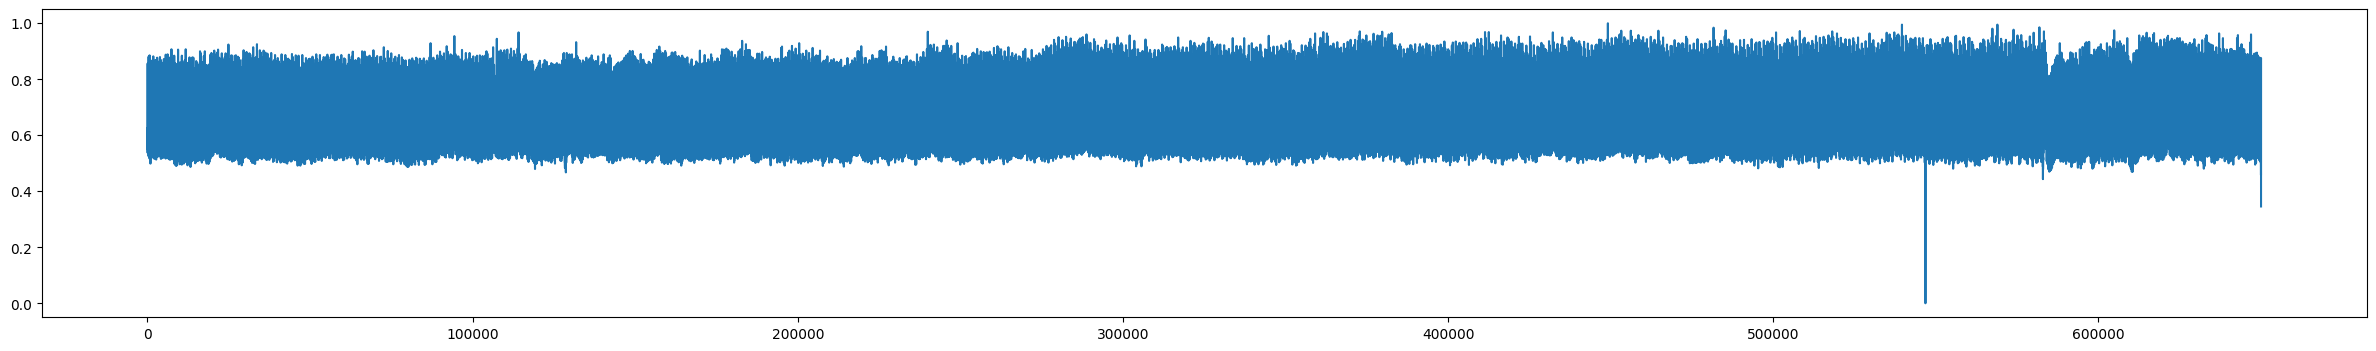

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
lm = min_max_scaler.fit_transform(record.p_signal[:,0].reshape(-1,1))
plt.figure(figsize=(30, 4))
plt.plot(lm)

In [9]:
wfdb.rdsamp(data+'100')

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 {'fs': 360,
  'sig_len': 650000,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V5'],
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})

In [10]:
ann = wfdb.rdann(data+"100", extension="atr")
ann.sample  

array([    18,     77,    370, ..., 649484, 649734, 649991])

In [27]:
df = []
window_size = 180 #seems to be common roughly three heartbeats
sliding_size = 90
for pat_id in patients:
    print('record number', pat_id)
    record = wfdb.rdrecord(data+'100',smooth_frames=True)
    min_max_scaler = preprocessing.MinMaxScaler()
    lm = min_max_scaler.fit_transform(record.p_signal[:,0].reshape(-1,1)).squeeze()
    for i in range(record.sig_len - window_size + 1):
        df.append(lm[i:i+window_size])


record number 100
record number 101
record number 102
record number 103
record number 104
record number 105
record number 106
record number 107
record number 108
record number 109
record number 111
record number 112
record number 113
record number 114
record number 115
record number 116
record number 117
record number 118
record number 119
record number 121
record number 122
record number 123
record number 124
record number 200
record number 201
record number 202
record number 203
record number 205
record number 207
record number 208
record number 209
record number 210
record number 212
record number 213
record number 214
record number 215
record number 217
record number 219
record number 220
record number 221
record number 222
record number 223
record number 228
record number 230
record number 231
record number 232
record number 233
record number 234


In [28]:
len(df)

31191408

In [31]:
df[0]

array([0.61927711, 0.61927711, 0.61927711, 0.61927711, 0.61927711,
       0.61927711, 0.61927711, 0.61927711, 0.6253012 , 0.62168675,
       0.61927711, 0.61807229, 0.61566265, 0.61686747, 0.61566265,
       0.61204819, 0.61084337, 0.60963855, 0.61325301, 0.61686747,
       0.61204819, 0.61084337, 0.60843373, 0.61084337, 0.61686747,
       0.62168675, 0.61686747, 0.60843373, 0.60481928, 0.59759036,
       0.6       , 0.59518072, 0.5939759 , 0.59156627, 0.58795181,
       0.58795181, 0.58795181, 0.59036145, 0.59277108, 0.59036145,
       0.58795181, 0.58433735, 0.58433735, 0.58433735, 0.58433735,
       0.58554217, 0.58313253, 0.58072289, 0.58554217, 0.58795181,
       0.58795181, 0.58674699, 0.58554217, 0.58072289, 0.58433735,
       0.58192771, 0.58674699, 0.58433735, 0.58192771, 0.57831325,
       0.57710843, 0.57349398, 0.56746988, 0.56144578, 0.56144578,
       0.55662651, 0.54457831, 0.5373494 , 0.5373494 , 0.55180723,
       0.5746988 , 0.60120482, 0.6373494 , 0.68313253, 0.74457

In [32]:
pd.DataFrame(df[:10000], columns=[f"t_{i}" for i in range(180)]).to_csv("data/mit_bih.csv")